# Tuning Confidence Score of Flight Call Detections
_Ashley Huang, Carlene English_, _Benjamin Van Doren_, _Kate Stone_

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.stats import gaussian_kde
from scipy.special import logit
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import suncalc
import os

# Create export directories
for path in ['exports', 'exports/csv', 'exports/figures']:
    if not os.path.exists(path):
        os.makedirs(path)

# Define consistent palette
palette = {'Present': 'tab:blue', 'Absent': 'tab:orange'}

In [12]:
taxon = 'semplo'

common_names = {
    'greyel': 'Greater Yellowlegs', 
    'semplo': 'Semipalmated Plover', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
    'baisan': 'Baird\'s Sandpiper', 
    'wilsni': 'Wilson\'s Snipe', 
    'leasan': 'Least Sandpiper'
}

## 1. Plot the distribution of confidence scores
To avoid confusion for the term ***reviewed***, we will be using ***Present*** and ***Absent*** when refering to review status.

`reviewStatus: Reviewed` -> ***Present***

`reviewStatus: Problem` -> ***Absent***

***Present*** or ***Absent*** -> ***Reviewed***

`reviewStatus: Unreviewed` -> ***Unreviewed***

reviewStatus
Present       122
Absent         71
Unreviewed     33
Name: count, dtype: int64

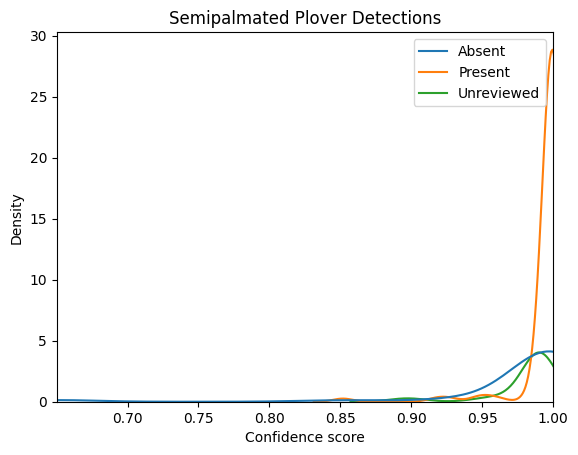

In [13]:
if taxon == 'uplsan':
    df_flood = pd.read_csv(f'detections/uplsan_flood.csv')
    df_present = pd.read_csv(f'detections/uplsan_present.csv')
    df_absent = pd.read_csv(f'detections/uplsan_absent.csv')
    df = pd.concat([df_flood, df_present, df_absent])
else:
    df = pd.read_csv(f'detections/{taxon}.csv')

# Filter by model, renamed status, and map to 0/1.
df = df[df['detectionModel'] == 'nfc_taxo141']
df['reviewStatus'] = df['reviewStatus'].map({'Reviewed': 'Present', 
                                             'Problem': 'Absent', 
                                             'Unreviewed': 'Unreviewed'})
df['reviewStatusBinary'] = df['reviewStatus'].map({'Present': 1, 
                                                   'Absent': 0, 
                                                   'Unreviewed': -1})

ax = sns.kdeplot(df, x='confidenceScore', hue='reviewStatus', bw_adjust=1)
ax.get_legend().set_title(None)
plt.title(f'{common_names[taxon]} Detections')
plt.xlabel('Confidence score')
plt.ylabel('Density')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.savefig(f'exports/figures/{taxon}_detections.png', dpi=300, bbox_inches='tight')

df['reviewStatus'].value_counts()

## 2. Filter Out Daytime Detections
First, we filter out unreviewed detections and assign 0/1 to absent/present detections. Then, we filter out daytime flight calls. Timestamps are compared to the sunset/sunrise time of MPG ranch. Once we obtained coordinated of each site, timestamp should be compared to the sunset/sunrise time of the corresponding site.

In [14]:
# Filter by sunset and sunrise time
def get_sameday_dawn_dusk(utc_time, lon, lat):
    # Turns out Suncalc doesn't return the times of the same day. 
    # Instead, if the time has passed sunset, Suncalc returns the times of the next day.
    next_sunset = suncalc.get_times(utc_time, lon, lat)
    prev_sunset = suncalc.get_times(utc_time - timedelta(days=1), lon, lat)
    if (next_sunset['nautical_dawn'] - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date():
        utc_dawn, utc_dusk = next_sunset['nautical_dawn'], next_sunset['nautical_dusk']
    else:
        utc_dawn, utc_dusk = prev_sunset['nautical_dawn'], prev_sunset['nautical_dusk']
    assert((utc_dawn - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    assert((utc_dusk - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    return utc_dawn, utc_dusk

def is_nocturnal(time_str, dawn_offset=timedelta(minutes=0), dusk_offset=timedelta(minutes=0)):
    utc_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    utc_dawn, utc_dusk = get_sameday_dawn_dusk(utc_time, -116.3273099, 47.0559593)
    if utc_dawn + dawn_offset < utc_time < utc_dusk + dusk_offset:
        return False
    else:
        return True

total_detections = len(df.index)
df = df[df['timestamp'].apply(is_nocturnal)]
print('nocturnal detections:', len(df.index))
print('durinal detections:', total_detections - len(df.index))

nocturnal detections: 77
durinal detections: 149


## 3. Resample Reviewed Detections to Match the Distribution of All Detections

In [15]:
density_offset = 0.1
scores_target = df['confidenceScore']
scores_reviewed = df[df['reviewStatus'] != 'Unreviewed']['confidenceScore']
kde_target = gaussian_kde(scores_target, bw_method=0.5)
kde_reviewed = gaussian_kde(scores_reviewed, bw_method=0.5)
weights = (kde_target.evaluate(scores_reviewed) + density_offset) / (kde_reviewed.evaluate(scores_reviewed) + density_offset)
weights /= weights.sum()

sample_size = len(df[df['reviewStatus'] != 'Unreviewed']) * 10
indicies = np.random.choice(df[df['reviewStatus'] != 'Unreviewed'].index, size=sample_size, p=weights, replace=True)
sample = df[df['reviewStatus'] != 'Unreviewed'].loc[indicies]

(0.902316375637054, 1.0)

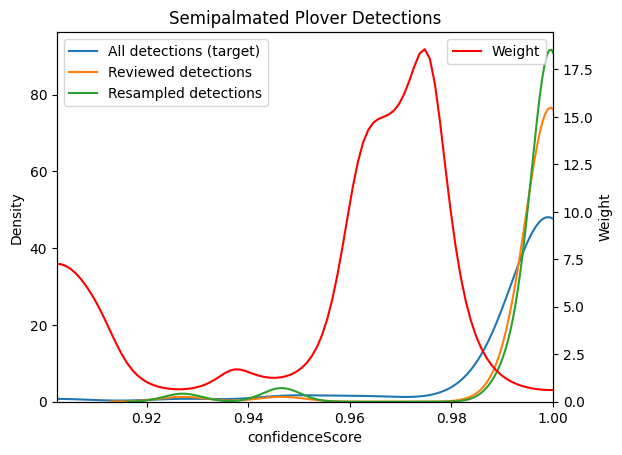

In [16]:
# Plot the distribution before and after resampling
scores = {
    'All detections (target)': df['confidenceScore'], 
    'Reviewed detections': df[df['reviewStatus'] != 'Unreviewed']['confidenceScore'], 
    'Resampled detections': sample['confidenceScore']
}

fig, ax1 = plt.subplots()
for label, data in scores.items():
    sns.kdeplot(data, label=label, bw_adjust=1, ax=ax1)
ax1.legend(loc='upper left')

x = np.linspace(0.9, 1.0, 100)
weights = weights = (kde_target.evaluate(x) + density_offset) / (kde_reviewed.evaluate(x) + density_offset)
ax2 = ax1.twinx()
ax2.plot(x, weights, label='Weight', color='red')
ax2.set_ylabel('Weight')
ax2.set_ylim(bottom=0)
ax2.legend(loc='upper right')

plt.title(f'{common_names[taxon]} Detections')
plt.xlabel('Confidence score')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)

## 5. Fit with Logistic Regression

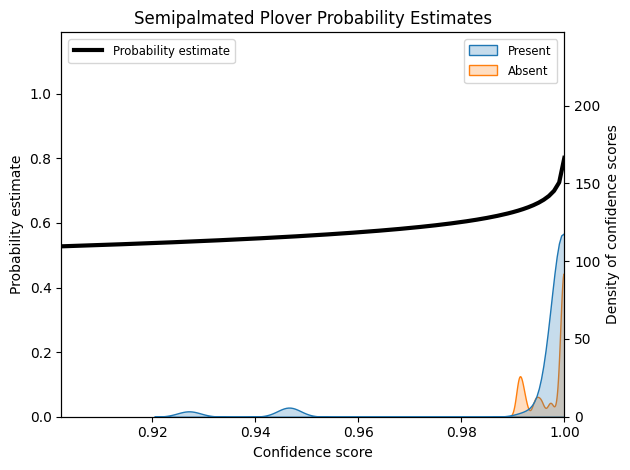

In [17]:
X = sample['confidenceScore'].values.reshape(-1, 1)
y = sample['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
logr = LogisticRegression()
logr.fit(X_logit, y)

# Predict y of x in [0, 1]
X_uniform = np.linspace(0, 1, 1000).reshape(-1, 1)
X_logit_plot = logit(X_uniform.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(X_logit_plot)[:, 1]

fig, ax1 = plt.subplots()
ax1.plot(X_uniform, y_hat, color='black', label='Probability estimate', linewidth=3)
ax1.set_xlim(df['confidenceScore'].quantile(1e-4), 1)
ax1.set_ylim(0, 1.19)
ax1.set_xlabel('Confidence score')
ax1.set_ylabel('Probability estimate')
ax1.set_title(f'{common_names[taxon]} Probability Estimates')
ax1.legend(loc='upper left')
for text in ax1.get_legend().get_texts():
    text.set_fontsize('small')

ax2 = ax1.twinx()
sns.color_palette('tab10')
sns.kdeplot(data=sample, x='confidenceScore', hue='reviewStatus', bw_adjust=0.5, 
            fill=True, palette=palette,legend=True, 
            ax=ax2)
ax2.set_ylabel('Density of confidence scores')
ax2.set_ylim(0, ax2.get_ylim()[1] * 2) # Scale KDE by 1/2 to not clutter up the figure
ax2.get_legend().set_title(None)
for text in ax2.get_legend().get_texts():
    text.set_fontsize('small')

plt.tight_layout()
plt.savefig(f'exports/figures/prob_w_dist_{taxon}.png', dpi=300, bbox_inches='tight')

(0.0, 1.19)

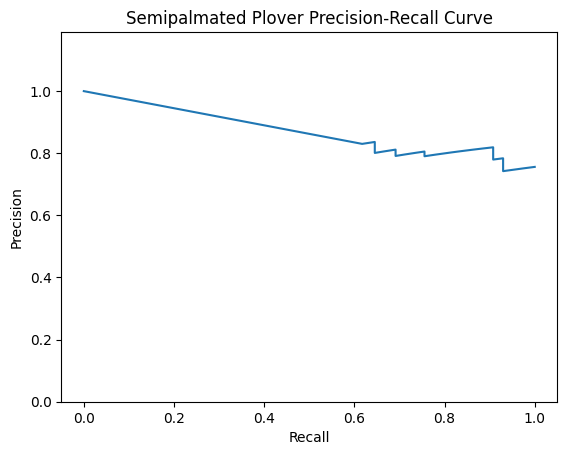

In [18]:
# Train logistic regression model
X = sample['confidenceScore'].values.reshape(-1, 1)
y = sample['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(X_logit)[:, 1]

precision, recall, threshold = precision_recall_curve(y, y_hat)
average_precision = average_precision_score(y, y_hat)
plt.plot(recall, precision)
plt.title(f'{common_names[taxon]} Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1.19)

At probability = 0.9
--- Precision = 0.83019
--- Recall = 0.61723



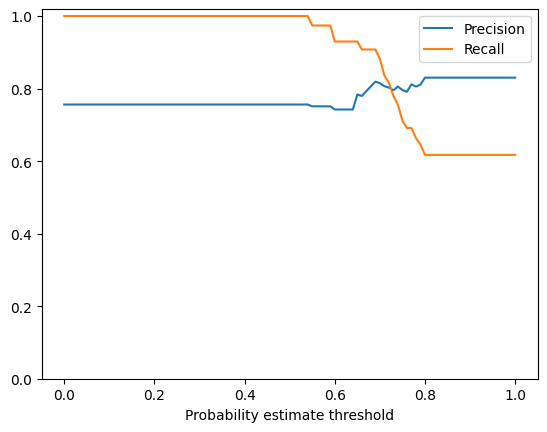

In [19]:
# Find precision and recall at target probability
p = list()
r = list()
target_probability = 0.9
for probability in np.linspace(0, 1, 101):
    idx = np.argmin(np.abs(threshold - probability))
    p.append(precision[idx])
    r.append(recall[idx])
    if probability == target_probability:
        print(f'At probability = {target_probability}')
        print(f'--- Precision = {precision[idx].round(5)}')
        print(f'--- Recall = {recall[idx].round(5)}\n')
plt.plot(np.linspace(0, 1, 101), p, label='Precision')
plt.plot(np.linspace(0, 1, 101), r, label='Recall')
plt.xlabel('Probability estimate threshold')
plt.ylim(bottom=0)
plt.legend()

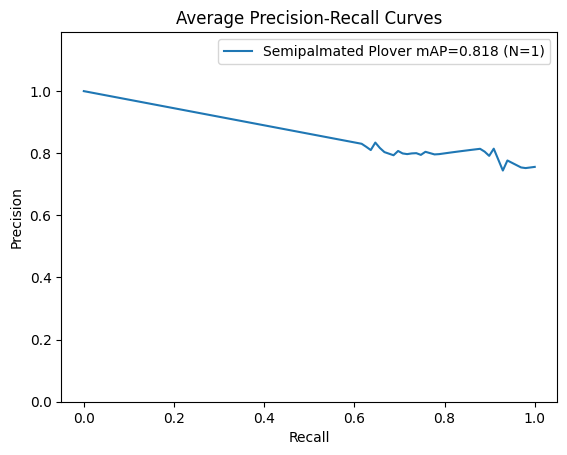

In [22]:
def interpolate_curves(pr_curves, average_precisions):
    recall_interp = np.linspace(0, 1, 100)
    precision_interp = list()
    for precision, recall in pr_curves:
        f = interp1d(recall, precision, kind='linear', bounds_error=False, fill_value='extrapolate')
        precision_interp.append(f(recall_interp))
    mean_precision_interp = np.mean(precision_interp, axis=0)
    mean_average_precision = np.mean(average_precisions)
    return recall_interp, mean_precision_interp, mean_average_precision
    
pr_curves = [(precision, recall)]
average_precisions = [average_precision]
recall_interp, mean_precision_interp, mean_average_precision = interpolate_curves(pr_curves, average_precisions)
plt.plot(recall_interp, mean_precision_interp, label=f'{common_names[taxon]} mAP={mean_average_precision.round(3)} (N={len(pr_curves)})')


plt.title('Average Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1.19)
plt.legend()
plt.savefig(f'exports/figures/average_pr_curves.png')